<a href="https://colab.research.google.com/github/icarussfalls/LSTM_NEPSE/blob/main/HIDCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [30]:
from google.colab import files
uploaded = files.upload()


Saving HI.csv to HI (1).csv


In [3]:
import io
df = pd.read_csv('HI.csv', index_col = 'Date', parse_dates=True)


For weighted price, I am using (0.2*Open)+(0.2Low)+(0.3*High)+(0.3*Close)
I also removed outliers

In [ ]:
df.describe()

,LTP,% Change,High,Low,Open,Weighted Price,%wp_change,Unnamed: 10
count,1351.000000,1351.000000,1351.000000,1351.000000,1351.000000,1349.000000,1349.000000,0.0
mean,228.445226,0.045078,234.081421,223.582013,229.037261,229.312474,0.000144,NaN
std,102.751878,2.735854,106.676537,99.384332,103.583814,103.420916,0.023047,NaN
min,118.000000,-10.000000,122.000000,116.000000,122.000000,119.600000,-0.105000,NaN
25%,153.500000,-1.430000,157.000000,150.000000,153.500000,154.400000,-0.011000,NaN
50%,188.000000,0.000000,191.000000,183.000000,186.000000,187.100000,-0.002000,NaN
75%,284.000000,1.120000,293.850000,278.500000,285.000000,285.500000,0.008000,NaN
max,588.000000,10.000000,606.000000,576.000000,606.000000,587.700000,0.107000,NaN


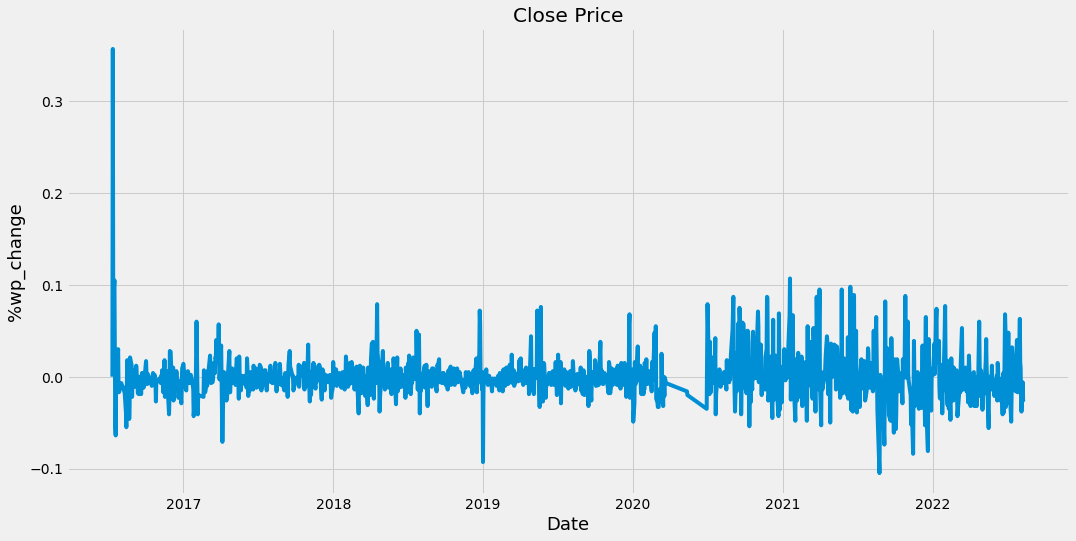

In [4]:
#visualize the closing price hostory
plt.figure(figsize=(16,8))
plt.title('Close Price')
plt.plot(df['%wp_change'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('%wp_change', fontsize = 18)
plt.show()

In [5]:
#create a new dataframe with only the close column
data = df.filter(['%wp_change'])
data.dropna()
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = round(len(dataset)*  .80)
training_data_len

1081

In [6]:
#scale the data
#apply preprocessing input datas before feeding to lstm model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset) #the range will be 0 to 1 inclusive

In [7]:
#create the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])


In [8]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#reshaoe the data lstm expecting three dimensional data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1021, 60, 1)

In [10]:
# build the lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1 )))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
#complile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#train the model
model.fit(x_train, y_train, batch_size =1, epochs = 200)

In [13]:
#saving the model for later use
model.save('hidcl.h5')

In [14]:
#downloading the model in local computer
files.download('hidcl.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# loading the model for future
# from numpy import loadtxt
# from tensorflow.keras.models import load_model
 
# load model
# model = load_model('api.h5')
# summarize model.
# model.summary()


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
#create the testing data settest_data = scaled_data[training_data_len - 60:, :]
#create the data set x_test and y_test
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test= dataset[training_data_len:, :]
for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [16]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [17]:
#reshape the data as data set needs to be three dimensional
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [18]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
#get the root mean squared error(RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

0.007485549416507733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


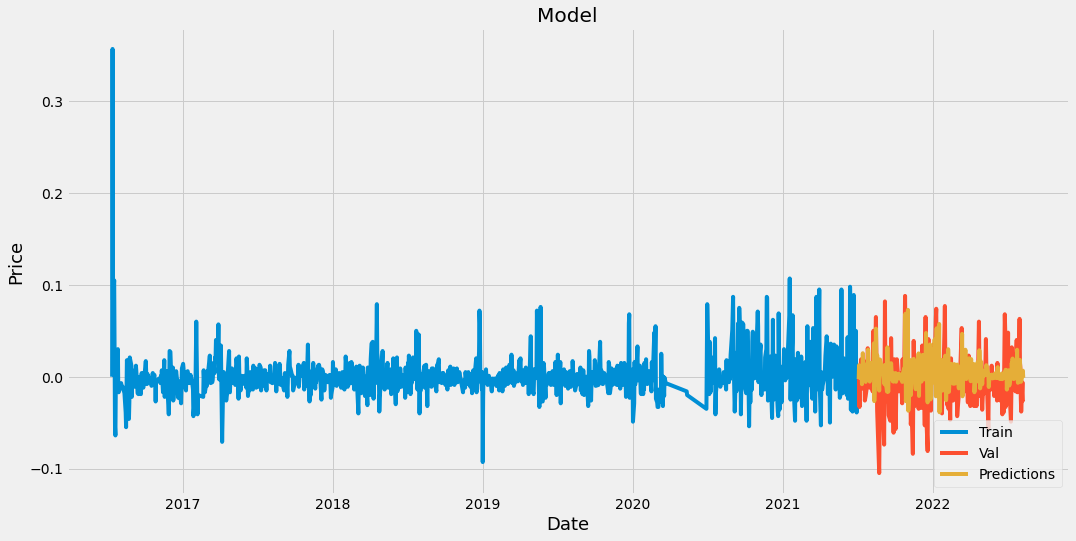

In [20]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Price', fontsize = 18)
plt.plot(train['%wp_change'])
plt.plot(valid[['%wp_change', 'Predictions' ]])
plt.legend(['Train', 'Val', 'Predictions'], loc= 'lower right')
plt.show()

In [31]:
#get the quote
quote = pd.read_csv('HI.csv')
a = quote.filter(['%wp_change'])
#get the last 60 days closing values and convert the dataframe to an array
last_60_days = a[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#create an empty list
X_test = []
#append the past 60 days to X_test list
X_test.append(last_60_days_scaled)
#convert the X_test data set to a numpy array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price  = float(pred_price)
print(pred_price)
#predicts next day price

-0.02076122909784317


In [32]:
#need to make a loop so that pred gets continuously feeded to the model
import warnings
import pandas as pd
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
def add(price):
  quote = pd.read_csv('HI.csv')
  a1 = quote.filter(['%wp_change'])
  a1 = a1.to_numpy()
  a2 = np.array(price)
  a3 = np.append(a1, a2)
  return a3

def pred_values(a4):
  a4 = a4.reshape(-1,1)
  last_60_dayss = a4[-60:]
  last_60_dayss = scaler.fit_transform(last_60_dayss)
  next_test = []
  next_test.append(last_60_dayss)
  next_test = np.array(next_test)
  next_test = np.reshape(next_test, (next_test.shape[0], next_test.shape[1], 1))
  price = model.predict(next_test)
  price = scaler.inverse_transform(price)
  return price

          


In [33]:
j = add(pred_price)
m = pred_values(j)
k = np.append(j,m)
m

array([[-0.02740507]], dtype=float32)

In [34]:
import sys
def funct(a,b, steps = 1):
      while steps < 30:
        e = np.append(a,b)
        d = pred_values(e)
        return funct(e,d, steps+1)
      else:
        return np.array(a)



In [35]:
y = funct(j,m)
y

array([ 0.        ,  0.357     ,  0.084     , ..., -0.02145639,
       -0.02137164, -0.02146776])

In [36]:
from datetime import datetime, timedelta

days = 30
daterange = []

for i in range(1, 30):
    tomorrow = datetime.now() + timedelta(days=i)
    if tomorrow.weekday() != 5:
        daterange.append(tomorrow.strftime('%m-%d'))

In [37]:
daterange.sort()
daterange

['08-12',
 '08-14',
 '08-15',
 '08-16',
 '08-17',
 '08-18',
 '08-19',
 '08-21',
 '08-22',
 '08-23',
 '08-24',
 '08-25',
 '08-26',
 '08-28',
 '08-29',
 '08-30',
 '08-31',
 '09-01',
 '09-02',
 '09-04',
 '09-05',
 '09-06',
 '09-07',
 '09-08',
 '09-09']

In [38]:
n = len(daterange)
y = y[-n:]

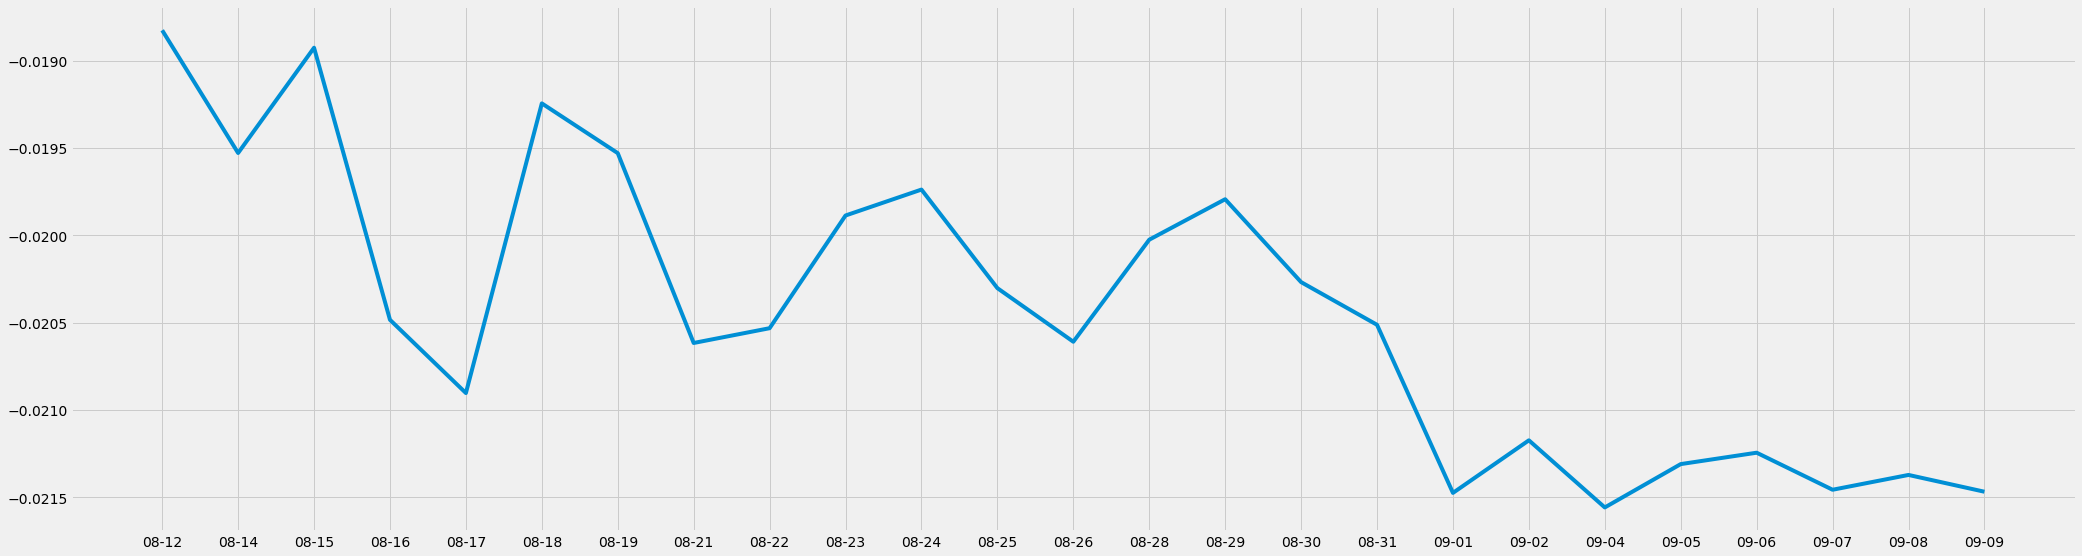

In [39]:
plt.figure(figsize=(32,9))
plt.plot(daterange,y)
plt.show()